# Tensorflow Functional API 

### Introduction

In this project I show how to use the Tensorflow `functional API within TF 2.0`. I will use the US Census Dataset and create a binary classification model. The data used has already been preprocessed, normalized and one-hot encoded. Data is stored within a Google Cloud Storage Bucket ready to be loaded into pandas dataframe or tensorflow dataset. 

### Importing Libraries

In [2]:
from collections import namedtuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import datetime
import functools


In [ ]:
!pip3 install tensorflow==2.0.0b1

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
tf.__version__

'2.0.0-beta0'

### Load Data from Google Cloud Storage

In [129]:
x_train_data = 'gs://crazy-hippo-01/dataset/x_train.csv'
x_test_data = 'gs://crazy-hippo-01/dataset/x_test.csv'
y_train_data = 'gs://crazy-hippo-01/dataset/y_train.csv'
y_test_data = 'gs://crazy-hippo-01/dataset/y_test.csv'
x_val = 'gs://crazy-hippo-01/dataset/x_val.csv'
y_val = 'gs://crazy-hippo-01/dataset/y_val.csv'

In [130]:
X_train = pd.read_csv(x_train_data)
y_train = pd.read_csv(y_train_data)
X_test = pd.read_csv(x_test_data)
y_test = pd.read_csv(y_test_data)
x_val = pd.read_csv(x_val)
y_val = pd.read_csv(y_val)

In [132]:
X_train.head()

,age,education_num,capital_gain,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,0.027397,0.600000,0.0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0.178082,0.666667,0.0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.506849,0.533333,0.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.356164,0.666667,0.0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.109589,0.533333,0.0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### Create Tensorflow Dataset

In [133]:
FEATURES = X_train.columns
NUMERIC_COLS = X_train.columns[:2]
CATEGORICAL_COLS = X_train.columns[2:]

In [134]:
def create_dataset(x, y, batch_size, type='TRAIN'):
    
    #Load Pandas DF into tf dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(x), y.values))
    
    #Apply shuffle, batch and repeat to the training data. For evaluation we apply batch.
    if type == 'TRAIN': 
        dataset = dataset.shuffle(1000).batch(batch_size).repeat()
    else: 
        dataset = dataset.batch(32)
    
    # We take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    
    return dataset
 

In [135]:
temp_dataset = create_dataset(X_train, y_train, 32, 'TRAIN')

In [136]:
type(temp_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [27]:
def show_batch(dataset):
    for data, label in dataset.take(1):
        for key, value in data.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
show_batch(temp_dataset)

## Functional API

In [116]:
def create_dnn_model(INPUTS, NUMERIC_COLS, CATEGORICAL_COLS):
    
    #Define Input Features
    INPUTS = INPUTS
    #NUMERIC_INPUTS = NUMERIC_COLS
    #CATEGORICAL_INPUTS = CATEGORICAL_COLS
    
    #Set up feature columns list
    feature_columns = []
    feature_layer_inputs = {}

    #categorical_features = {
    #thal = feature_column.categorical_column_with_vocabulary_list(
    #  'thal', ['fixed', 'normal', 'reversible'])
    #    colname : tf.feature_column.indicator_column(colname)
    #    for colname in CATEGORICAL_INPUTS
    #}
    
    #Add numeric columns to list
    #numeric_columns = {
    #    colname : tf.feature_column.numeric_column(colname)  
    #        for colname in INPUTS
    #}
    
    for colname in INPUTS:
        feature_columns.append(tf.feature_column.numeric_column(colname))
        feature_layer_inputs[colname] = tf.keras.Input(shape=(1,), name=colname) 
        
        #feature_layer_inputs[header] = tf.keras.Input(shape=(1,), name=header)


    #feature_columns.append(numeric_columns)    
    
    #Define all the inputs
    #inputs = {
    #    colname : tf.keras.layers.Input(name=colname, shape=(1,), dtype=tf.float32)  
    #        for colname in INPUTS
    #}
    
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    dnn_input = feature_layer(feature_layer_inputs)
        
    #Inputs to model
    #dnn_input = tf.keras.layers.DenseFeatures(feature_columns[0].values())(inputs)
    
    #Layer One
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_input)
    
    #Layer Two
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)
    
    #Model Output
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(h2)
    
    model = keras.Model(feature_layer_inputs, output)
    #model = keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=output)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

func_model = create_dnn_model(FEATURES, NUMERIC_COLS, CATEGORICAL_COLS)
print('Your model has been built....')


Your model has been built....


In [117]:
func_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
capital_gain (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
education_num (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender_Female (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

## Input Parameters

In [118]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(X_train) # training dataset repeats, so it will wrap around
EPOCHS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 100 # enough to get a reasonable sample, but not so much that it slows down

## Train Model

In [119]:
train_dataset = create_dataset(X_train, y_train, TRAIN_BATCH_SIZE, 'TRAIN')
eval_dataset = create_dataset(x_val, y_val, TRAIN_BATCH_SIZE, 'EVAL').take(NUM_EVAL_EXAMPLES)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * EPOCHS)


history = func_model.fit(train_dataset,
     epochs= EPOCHS,
     verbose=1, 
     steps_per_epoch=steps_per_epoch, 
     validation_data=eval_dataset,
         )

Epoch 1/5
122/122 [==============================] - 3s 23ms/step - loss: 0.5930 - acc: 0.6721 - val_loss: 0.4589 - val_acc: 0.7678
Epoch 2/5
122/122 [==============================] - 2s 13ms/step - loss: 0.4274 - acc: 0.8007 - val_loss: 0.3910 - val_acc: 0.8166
Epoch 3/5
122/122 [==============================] - 2s 13ms/step - loss: 0.3879 - acc: 0.8194 - val_loss: 0.3796 - val_acc: 0.8169
Epoch 4/5
122/122 [==============================] - 2s 13ms/step - loss: 0.3749 - acc: 0.8225 - val_loss: 0.3718 - val_acc: 0.8200
Epoch 5/5
122/122 [==============================] - 2s 13ms/step - loss: 0.3855 - acc: 0.8171 - val_loss: 0.3688 - val_acc: 0.8219


## Evaluate Model

In [120]:
test_dataset = create_dataset(X_test, y_test, TRAIN_BATCH_SIZE, 'TEST')

test_loss, test_acc = func_model.evaluate(test_dataset, steps=20)

20/20 [==============================] - 0s 7ms/step - loss: 0.3534 - acc: 0.8328


## Visualize Training

In [121]:
import matplotlib.pyplot as plt

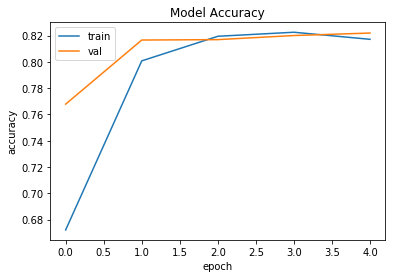

In [122]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Export SavedModel

In [123]:
args = {'output_dir' : 'gs://crazy-hippo-01/ai-platform/ml_engine_training'}

In [ ]:
import shutil, os, datetime
args['output_dir'] = os.path.join(args['output_dir'], 'export/savedmodel')
if args['output_dir'][:5] != 'gs://':
    shutil.rmtree(args['output_dir'], ignore_errors=True)
EXPORT_PATH = os.path.join(args['output_dir'], datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(func_model, EXPORT_PATH)

In [124]:
save_path = os.path.join(args['output_dir'],'export/savedmodel')
func_model.save(save_path)

INFO:tensorflow:Assets written to: gs://crazy-hippo-01/ai-platform/ml_engine_training/export/savedmodel/assets


AttributeError: 'NoneType' object has no attribute 'get_config'